In [1]:
# https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data-130k-v2.csv

In [2]:
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from sklearn.neighbors import LocalOutlierFactor

from lightgbm import LGBMClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('seaborn-deep')
sns.set()


%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [17]:
data = pd.read_csv('winemag-data-130k-v2.csv')

In [18]:
data.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [19]:
data = data.drop('Unnamed: 0', axis=1)

## Help function

In [291]:
def missing_value(values, p):
    px = np.random.random()
    ix = 0
    for i in p:
        if px < i: break
        ix += 1
    return values[ix][0]

## Analysis data, Clear and Preproc

In [532]:
data.shape

(129971, 13)

In [533]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [534]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


<AxesSubplot:>

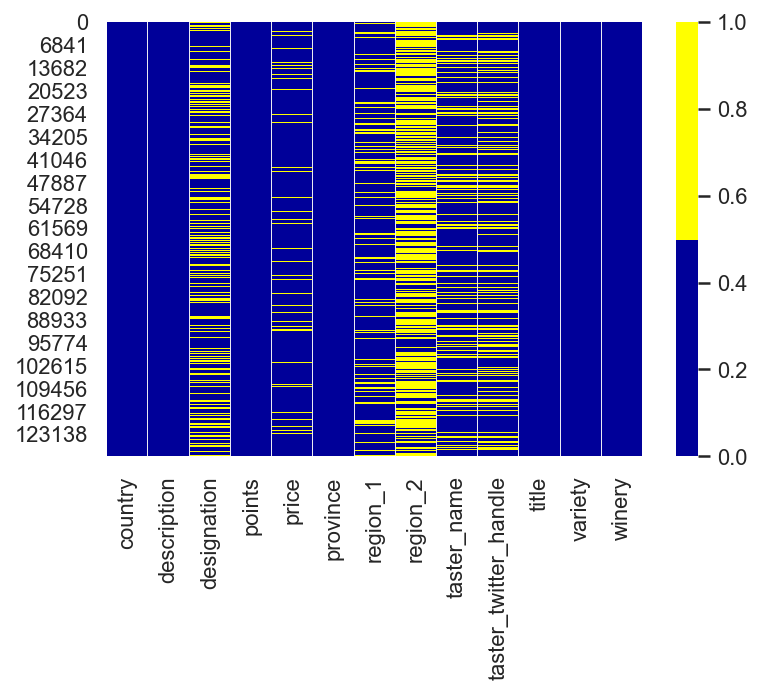

In [535]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=colours)

In [536]:
data.isnull().mean() * 100

country                   0.048472
description               0.000000
designation              28.825661
points                    0.000000
price                     6.921544
province                  0.048472
region_1                 16.347493
region_2                 61.136715
taster_name              20.192197
taster_twitter_handle    24.015357
title                     0.000000
variety                   0.000769
winery                    0.000000
dtype: float64

In [537]:
# replace NaN 

dataC = data.copy()

for col in dataC.columns:
    
    if dataC[col].value_counts(normalize=True).count() <= 50 and \
                                   dataC[col].isnull().any() and \
                                   dataC[col].dtype not in ['int', 'float']:
                
        print(f'probabilistic substitution: {col}')
        
        values = data[[col]].value_counts(normalize=True).index.tolist()
        p = data[[col]].value_counts(normalize=True).cumsum().tolist()
        
        dataC[col] = dataC[col].map(lambda x: x if not (x is np.nan) else missing_value(values, p))
    
    elif dataC[col].value_counts(normalize=True).count() > 50 and \
                                    dataC[col].isnull().any() and \
                                    dataC[col].dtype not in ['int', 'float']:
                
        print(f'random substitution: {col}')
        
        values = data[[col]].value_counts(normalize=True).index.tolist()
        len_values = len(values)
        dataC[col] = dataC[col].map(lambda x: x if not (x is np.nan) else values[np.random.randint(len_values)][0])
        
    elif dataC[col].isnull().any():
        print(f'mean substitution: {col}')
        
        dataC[col] = dataC[col].fillna(dataC[col].mean())
        

probabilistic substitution: country
random substitution: designation
mean substitution: price
random substitution: province
random substitution: region_1
probabilistic substitution: region_2
probabilistic substitution: taster_name
probabilistic substitution: taster_twitter_handle
random substitution: variety


In [538]:
dataC.isnull().mean() * 100

country                  0.0
description              0.0
designation              0.0
points                   0.0
price                    0.0
province                 0.0
region_1                 0.0
region_2                 0.0
taster_name              0.0
taster_twitter_handle    0.0
title                    0.0
variety                  0.0
winery                   0.0
dtype: float64

In [568]:
dataC.head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,North Coast,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,Oltrepò Pavese,California Other,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",Hallgartener Jongfer Spätlese Goldkap,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Central Coast,Alexander Peartree,@paulgwine,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.000000,Northern Spain,Navarra,Columbia Valley,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.000000,Sicily & Sardinia,Vittoria,Sonoma,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,Electus,87,24.000000,Alsace,Alsace,Central Coast,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.000000,Rheinhessen,Côte Rôtie,Sonoma,Anna Lee C. Iijima,@wineschach,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.000000,Alsace,Alsace,Central Coast,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [554]:
for col in dataC.columns:
    print(f'{col} : {dataC[col].value_counts().count()}')

country : 43
description : 119955
designation : 37979
points : 21
price : 391
province : 425
region_1 : 1229
region_2 : 17
taster_name : 19
taster_twitter_handle : 15
title : 118840
variety : 707
winery : 16757


In [569]:
dataC['points'].value_counts(normalize=True)

88     0.132391
87     0.130283
90     0.118565
86     0.096945
89     0.094067
91     0.087396
92     0.073963
85     0.073324
93     0.049927
84     0.049857
94     0.028914
83     0.023274
82     0.014126
95     0.011810
81     0.005324
96     0.004024
80     0.003055
97     0.001762
98     0.000592
99     0.000254
100    0.000146
Name: points, dtype: float64

In [567]:
dataC['description']

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 129971, dtype: object